## Dataset Information

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

In [91]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import random
np.random.seed(43)

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [92]:
df = pd.read_csv('creditcard.csv')
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


## 1. Non-Fraud vs Fraud

In [93]:
counts = df['Class'].value_counts()
counts

0    284315
1       492
Name: Class, dtype: int64

## 2. Relation with Time and fraud
- 1시간 간격에 따른 Fraud 비율의 분포(조건부 분포)

In [94]:
max_time = max(df["Time"])
print('max_time:', max_time)
min_time = min(df["Time"])
print('min_time:', min_time)

max_time: 172792.0
min_time: 0.0


In [95]:
hour = 60*60
bins = list(range(int(min(df['Time'])), int(max(df['Time']))+9, hour))
df_copy = df.copy()
df_copy['Time_group'] = pd.cut(df_copy['Time'], bins, right=False, labels = list(range(1, len(bins), 1)))

### time 변수 전처리
- 1. 하루 24 * 60 * 60 초를 mod로 하여 변환 - y과 time의 관계가 비선형임을 참고



밑의 2,3 과정은 train set에 대해 oversampling 적용한 다음 train, validation, test set에 일괄적으로 진행
- 2. 1시간 단위로 그룹화한 다음, 24mod 적용 - 그룹화했을 뿐, 여전히 y와 time의 관계가 비선형
- 3. 2시간 단위로 그룹화한 다음, 12mod를 적용한 후, dummy변수로 펼침 - Lasso와 같이 비선형을 잡아내지 못하는 모형을 돌릴 때 추천(2시간 단위로 그래프를 보면 더욱 매끄러워서 2시간으로 그룹화함)

In [96]:
''' Time_1hour : 2번
df['Time_1hour'] = pd.cut(df['Time'], bins, right=False, labels = list(range(1, len(bins),1)))
df['Time_1hour'] = df['Time_1hour'].astype(int)
df.loc[df.Time_1hour>24, 'Time_1hour'] = df.loc[df.Time_1hour>24, 'Time_1hour']-24
'''

" Time_1hour : 2번\ndf['Time_1hour'] = pd.cut(df['Time'], bins, right=False, labels = list(range(1, len(bins),1)))\ndf['Time_1hour'] = df['Time_1hour'].astype(int)\ndf.loc[df.Time_1hour>24, 'Time_1hour'] = df.loc[df.Time_1hour>24, 'Time_1hour']-24\n"

In [97]:
'''
# two_hour_1, two_hour_2, two_hour_3,,,, two_hour12 : 3번
bins = list(range(int(min(df['Time'])), int(max(df['Time']))+9, hour*2))
df['two_hour'] = pd.cut(df['Time'], bins, right=False, labels = list(range(1, len(bins), 1)))
df['two_hour'] = df['two_hour'].astype(int)
df.loc[df.two_hour>12, 'two_hour'] = df.loc[df.two_hour>12, 'two_hour']-12
df = pd.get_dummies(df, columns = ['two_hour'])
'''

"\n# two_hour_1, two_hour_2, two_hour_3,,,, two_hour12 : 3번\nbins = list(range(int(min(df['Time'])), int(max(df['Time']))+9, hour*2))\ndf['two_hour'] = pd.cut(df['Time'], bins, right=False, labels = list(range(1, len(bins), 1)))\ndf['two_hour'] = df['two_hour'].astype(int)\ndf.loc[df.two_hour>12, 'two_hour'] = df.loc[df.two_hour>12, 'two_hour']-12\ndf = pd.get_dummies(df, columns = ['two_hour'])\n"

In [98]:
# Time_sec : 1번
df.loc[df.Time>=(hour)*24, 'Time'] = df.loc[df.Time>=(hour)*24, 'Time']-(hour*24)
df = df.rename(columns={"Time":"Time_sec"})

## 3. About PCs(V1, V2, .. V28)
### 3-1. feature 간 상관관계
- Principal components(V1~V28) 간에 상관관계는 없다.
- 몇몇 PC는 Time, Amount와 유의미한 상관관계를 가진다.

### 3-2. Distributions of V1, V2,,,, on y=0 and y=1 
- y를 예측하는데 의미없어보이는 변수들도 있어 보인다 : V13, V15, V22, V24, V25, V26

### 3-3. Conditional Probabilty of y over V1, V2,,,
- 특정 변수에서 특정 구간에 속할 경우, fraud일 확률이 급격히 올라감을 알 수 있다.
- 단순한 선형모형으로는 좋은 분류 모델을 만들기 어려울 것으로 판단된다.
- 만약 overfitting이 문제가 된다면, 아래 분포 중 극단적인 분포를 갖는 feature에서 이상치를 제거해야 할 것이다. 심지어 중간 값을 빼줘야 할지도 모른다. 특정 구간에서 y=1일 확률이 1.0에 가깝게 판단이 되는 이유는 특정 구간에 속한 데이터가 몇 개 안 되는 데 그 몇 개 안 되는 데이터가 모두 y=1이기 때문이다. 이게 유용한 단서가 될수도, Overfitting을 야기할 수 있다.

## 4. About Amount
### 4-1. 기초 통계량 & Dist of Amount on y=1 and y=0
- 사기거래의 거래금액이 평균적으로 크다.
- 그러나 거래금액이 크다고 사기거래일 확률이 높아지는 것이 아니다.
- 그래프를 통해 알 수 있듯이, 1000\\$ 정도가 넘어가는 거래는 대부분 정상거래이다. 특히 사기거래의 Max Amount는 2126\\$ 이다.
- 다만 정상거래는 Amount가 낮은 경우가 압도적으로 많기 때문에 정상거래의 거래금액 평균이 낮아진 것이다.

In [99]:
mean_am_1 = df.loc[df.Class==1, 'Amount'].describe()[1]
st_am_1 = df.loc[df.Class==1, 'Amount'].describe()[2]
print(f'Mean of Amounts over fraud transactions is {np.round(mean_am_1)}, and standard deviation is {np.round(st_am_1)}')

Mean of Amounts over fraud transactions is 122.0, and standard deviation is 257.0


In [100]:
mean_am_0 = df.loc[df.Class==0, 'Amount'].describe()[1]
st_am_0 = df.loc[df.Class==0, 'Amount'].describe()[2]
print(f'Mean of Amounts over non-fraud transactions is {np.round(mean_am_0)}, and standard deviation is {np.round(st_am_0)}')

Mean of Amounts over non-fraud transactions is 88.0, and standard deviation is 250.0


### 4-2. Conditional probabilty of y=1 over Transaction Amount
- 거래 금액이 일정 수준 클 경우, 오히려 사기거래일 확률이 급격히 떨어짐을 알 수 있음

## 4-3. 로그변환
- 위의 Distribution of Transaction Amount 그래프에서 볼 수 있듯이, right-skewed 된 분포이다.
- 따라서 표준화하기 전에 로그변환으로 치우친 정도를 완화시키자. 
- Amount = 0인 거래의 경우, 0.001로 대체한다. 0 다음으로 작은 Amount가 0.25이니, 0을 0.001로 대체해도 큰 무리는 없을 것으로 판단된다.
- 다만 Amount = 0인 거래가 특별한 의미가 있을 수 있어서, 논의가 필요해보인다.

In [101]:
df.loc[df['Amount']==0, 'Amount'] = 0.001

df['Amount'] = np.log(df['Amount'])

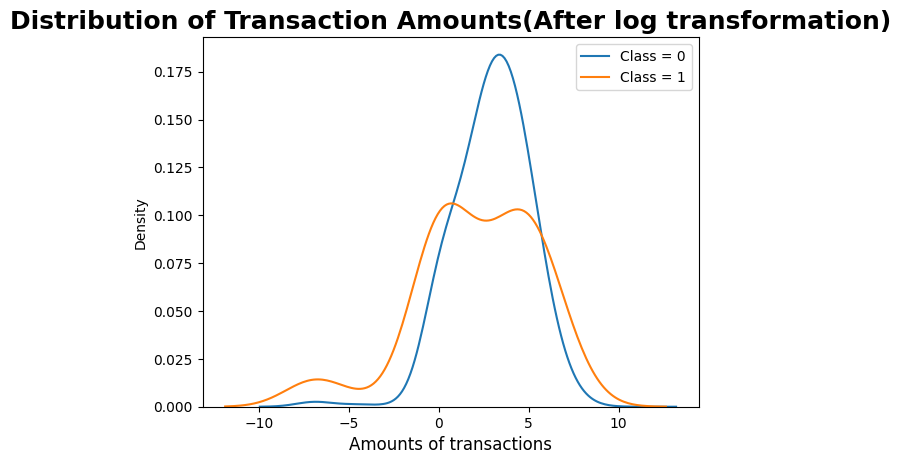

In [102]:
c0 = df.loc[df['Class'] == 0]
c1 = df.loc[df['Class'] == 1]
plt.figure()
sns.kdeplot(c0["Amount"], bw=0.5, label="Class = 0") 
sns.kdeplot(c1["Amount"], bw=0.5, label="Class = 1")
plt.xlabel("Amounts of transactions", fontsize=12)
plt.title("Distribution of Transaction Amounts(After log transformation)", fontdict={'fontweight':'bold', 'fontsize': 18})
plt.legend()
plt.show();

### 5-1. 이상치에 관한 의사결정
- log 변환 이후 Amount 분포를 살펴본 결과, Amount의 이상치는 제거하지 않기로 결정
- Principle components(V1, V2,,,)의 이상치가 class 0, 1을 분류하는데 결정적인지 분포를 확인해보자.

- 몇몇 feature에서 class=0에서 과한 이상치들이 관측된다(e.g. V27, V28, V7)
- 20*iqr을 기준으로 하여 이상치를 upper bound, lower bound로 대치하기로 결정.

In [103]:
pc = ["V"+str(i) for i in range(1,29)]
for feature in pc:
    q1 = np.percentile(df[feature], 25)
    q3 = np.percentile(df[feature], 75)
    iqr = q3-q1
    threshold = 20* iqr
    upper = q3+threshold
    lower = q1-threshold
    df.loc[df[feature]>upper, feature] = upper
    df.loc[df[feature]<lower, feature] = lower


- 이상치 처리 이후 분포

## 7. Standard Scaling
- V1,, V28 : PCA 과정에서 이미 수행됨
- Amount : log 변환을 통해 어느정도 scaling이 이루어졌다고 판단
- Time : 필요시, oversampling 이후에 수행

## 8. Data split & OverSampling

### 8-1. Train : Test = 8:2

In [104]:
train, test = train_test_split(df, test_size = 0.2, random_state = 42)
x_train = train.drop(['Class'],axis = 1)
y_train = train['Class']
x_test = test.drop(['Class'], axis=1)
y_test = test['Class']

In [105]:
print(x_train.shape, y_train.shape)
print(x_train.columns)

(227845, 30) (227845,)
Index(['Time_sec', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')


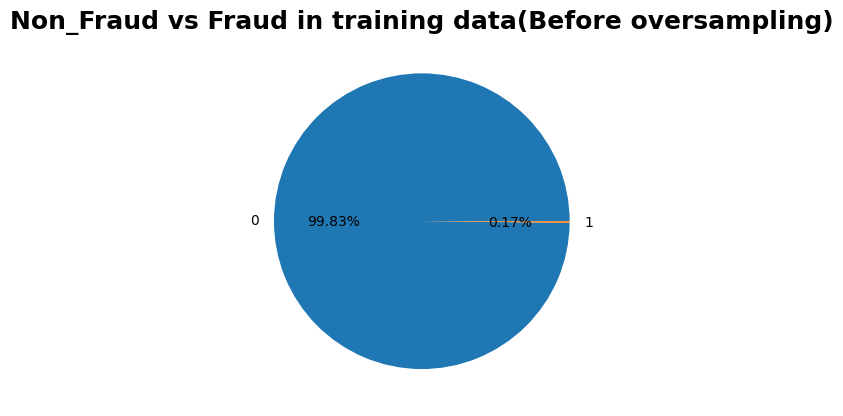

In [106]:
counts = y_train.value_counts()
labels = ["0","1"]
plt.pie(counts,labels = labels, autopct='%1.2f%%')
plt.title('Non_Fraud vs Fraud in training data(Before oversampling)', fontdict={'fontweight':'bold', 'fontsize': 18})
plt.show()

### 8-2. Oversampling 수행
- highly imbalanced data set -> OverSampling for better model
- Oversampling function : V1~V28은 정규분포를 따른다고 가정(LLN) ->               각 열마다 minority class에서의 정규분포에서 랜덤 샘플링
- time의 경우 V1,V2,,, 들과 어느정도 상관관계를 지님. 따라서 독립적으로 뽑지 않고, time_sec를 선형회귀분석으로 예측해서 채움.

In [107]:

def over_sampling(X_set, y_set, r = 1):
    
    data_df = pd.concat([X_set, y_set], axis=1)

    y_predict_time = X_set['Time_sec']
    x_predict_time = X_set.drop(["Time_sec"],axis = 1)
    x_predict_time["Class"] = y_set
    
    linear = LinearRegression(fit_intercept=True)
    linear.fit(x_predict_time,y_predict_time)
    
    n = len(data_df.loc[data_df['Class'] == 0])
    k1 = len(data_df.loc[data_df['Class'] == 1])
    k2 = math.ceil(n*r)-k1

    m = len(data_df['Class'])
    t1 = data_df.loc[data_df['Class'] == 1]
    col_list = list(data_df.columns)
    df_sample = pd.DataFrame([], index = range(m,m+k2))
    col_list.remove("Time_sec")
    for col in col_list:
        mu = t1[col].mean()
        sig = t1[col].std()
        
        df_sample[col] = np.random.normal(loc = mu, scale = sig, size = k2)
    
    predicted_time = linear.predict(df_sample)
    df_sample["Time_sec"] = predicted_time
    df_sample["Time_sec"] = df_sample["Time_sec"].astype(int)
    df_sample['Time_sec'] %= (60*60)*24
    df_sample['Class'] = 1
        
    
    merged_df = pd.concat([data_df, df_sample])
    X_sample = merged_df.drop(["Class"], axis = 1)
    y_sample = merged_df["Class"]
    
    return (X_sample, y_sample)

In [108]:

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Define the oversampler
oversampler = RandomOverSampler(sampling_strategy='minority')
undersampler = RandomUnderSampler(sampling_strategy = 1)
#SMOTE
oversampler = SMOTE()

''' 
kind: A string parameter that specifies the type of SMOTE to use. The options are 'regular', 'borderline1', 'borderline2', 'svm', or 'all'. The default is 'regular'.
out_step: A float parameter that specifies the step size when interpolating new samples. The default is 0.5.
m_neighbors: An integer parameter that specifies the number of nearest neighbors to use when selecting minority class samples to oversample. The default is 5.
svm_estimator: An object parameter that specifies the estimator object used for the SVM-based SMOTE variant. The default is None.
n_jobs: The number of CPU cores to use for parallelization. The default is 1.
verbose: A verbosity level for logging. The default is 0.
'''

# Fit and transform the data
#x_train, y_train = oversampler.fit_resample(x_train, y_train)
x_train, y_train = undersampler.fit_resample(x_train,y_train)


In [27]:
x_train, y_train = over_sampling(x_train,y_train)

### 8-3. Oversampling 결과

In [109]:
print(x_train.shape, y_train.shape)
print(x_train.columns)

(788, 30) (788,)
Index(['Time_sec', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')


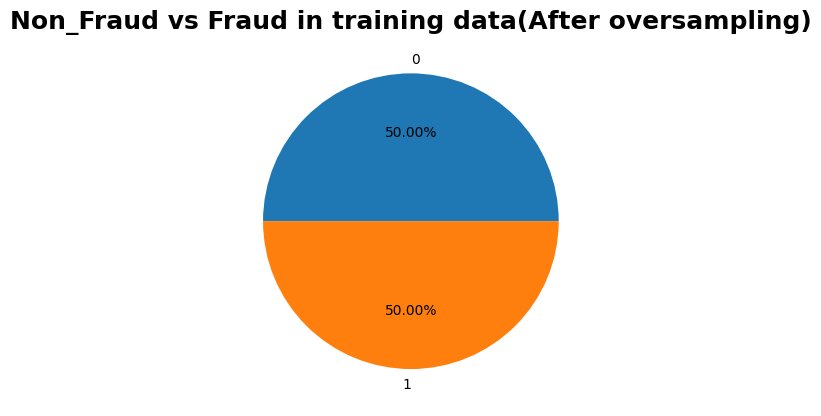

In [110]:
counts = y_train.value_counts()
labels = ["0","1"]
plt.pie(counts,labels = labels, autopct='%1.2f%%')
plt.title('Non_Fraud vs Fraud in training data(After oversampling)', fontdict={'fontweight':'bold', 'fontsize': 18})
plt.show()

### 8-4. Time에 대한 추가적인 전처리

- 위에서 설명했던 2번, 3번에 대한 코드
- Time_1hour : 1시간 단위로 그룹화한 다음, 24mod 적용 - 그룹화했을 뿐, 여전히 y와 time의 관계가 비선형
- two_hour 더미변수 : 2시간 단위로 그룹화한 다음, 12mod를 적용한 후, dummy변수로 펼침 - Lasso와 같이 비선형을 잡아내지 못하는 모형을 돌릴 때 추천(2시간 단위로 그래프를 보면 더욱 매끄러워서 2시간으로 그룹화함)
- 모델에 맞게 Time_sec, Time_1hour, two_hour 중 하나 사용
- Time_sec나 Time_1hour를 활용한다면, Time_sec에 한해서만 standard scaling 할 것을 추천

In [57]:
#Time_sec를 사용할 경우(Default), standard scaling
sc = StandardScaler()
train_time, test_time = pd.DataFrame(x_train['Time_sec']), pd.DataFrame(x_test['Time_sec'])


x_train['Time_sec'], x_test['Time_sec'] = sc.fit_transform(train_time), sc.fit_transform(test_time)


In [58]:
#Time_1hour 사용할 경우 & standard scaling
'''
hour = 60*60
bins = list(range(0, 86401, hour))

x_train['Time_1hour'] = pd.cut(x_train['Time_sec'], bins, right=False, labels = list(range(1, len(bins), 1)))
x_train['Time_1hour'] = x_train['Time_1hour'].astype(int)
x_train.drop(['Time_sec'], axis=1, inplace = True)

x_test['Time_1hour'] = pd.cut(x_test['Time_sec'], bins, right=False, labels = list(range(1, len(bins), 1)))
x_test['Time_1hour'] = x_test['Time_1hour'].astype(int)
x_test.drop(['Time_sec'], axis=1, inplace = True)


sc = StandardScaler()
train_time, test_time = pd.DataFrame(x_train['Time_1hour']), pd.DataFrame(x_test['Time_1hour'])
x_train['Time_1hour'], x_test['Time_1hour'] = sc.fit_transform(train_time), sc.fit_transform(test_time)
'''

"\nhour = 60*60\nbins = list(range(0, 86401, hour))\n\nx_train['Time_1hour'] = pd.cut(x_train['Time_sec'], bins, right=False, labels = list(range(1, len(bins), 1)))\nx_train['Time_1hour'] = x_train['Time_1hour'].astype(int)\nx_train.drop(['Time_sec'], axis=1, inplace = True)\n\nx_test['Time_1hour'] = pd.cut(x_test['Time_sec'], bins, right=False, labels = list(range(1, len(bins), 1)))\nx_test['Time_1hour'] = x_test['Time_1hour'].astype(int)\nx_test.drop(['Time_sec'], axis=1, inplace = True)\n\n\nsc = StandardScaler()\ntrain_time, test_time = pd.DataFrame(x_train['Time_1hour']), pd.DataFrame(x_test['Time_1hour'])\nx_train['Time_1hour'], x_test['Time_1hour'] = sc.fit_transform(train_time), sc.fit_transform(test_time)\n"

In [111]:
#two_hour 더미변수를 time feature로 사용할 경우
#two_hour_1, two_hour_2, two_hour_3,,,, two_hour12

hour = 60*60
bins = list(range(0, 86401, hour*2))

x_train['two_hour'] = pd.cut(x_train['Time_sec'], bins, right=False, labels = list(range(1, len(bins), 1)))
x_train['two_hour'] = x_train['two_hour'].astype(int)
x_train.drop(['Time_sec'], axis=1, inplace = True)
x_train = pd.get_dummies(x_train, columns=['two_hour'])

x_test['two_hour'] = pd.cut(x_test['Time_sec'], bins, right=False, labels = list(range(1, len(bins), 1)))
x_test['two_hour'] = x_test['two_hour'].astype(int)
x_test.drop(['Time_sec'], axis=1, inplace = True)
x_test = pd.get_dummies(x_test, columns=['two_hour'])


In [112]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_curve, auc

## Xgboost 

In [113]:
from xgboost import XGBClassifier

In [114]:
X_test_xgb = x_test.copy()
y_test_xgb = y_test.copy()

X_train_xgb = x_train.copy()
y_train_xgb = y_train.copy()

In [115]:
#X_val_xgb, X_test_xgb, y_val_xgb, y_test_xgb = train_test_split(x_test, y_test, test_size=0.5, random_state=42)
#evals = [(X_val_xgb, y_val_xgb)]

In [116]:
#xgb_wrapper = XGBClassifier(n_estimators= 100, learning_rate = 0.1, max_depth = 3,objective= "multi:softmax", num_classes = 2) 
xgb_wrapper = XGBClassifier(n_estimators= 300, learning_rate = 0.05, max_depth = 5, gamma = 50, random_state = 42)
#evals = [(X_test_xgb, y_test_xgb)]
xgb_wrapper.fit(X_train_xgb, y_train_xgb)

xgb_preds = xgb_wrapper.predict(X_test_xgb)
xgb_pred_probs = xgb_wrapper.predict_proba(X_test_xgb)[:,1]

In [117]:
confusion = confusion_matrix(y_test_xgb, xgb_preds)
accuracy = accuracy_score(y_test_xgb, xgb_preds)
precision = precision_score(y_test_xgb, xgb_preds)
recall = recall_score(y_test_xgb, xgb_preds)
f1 = f1_score(y_test_xgb, xgb_preds)
# ROC-AUC
roc_auc = roc_auc_score(y_test_xgb, xgb_pred_probs)
print('오차 행렬')
print(confusion)
# ROc-AUC
print("precision : {:.4f}, recall : {:.4f},\
    f1-score : {:.4f}".format(precision,recall,f1))


오차 행렬
[[55940   924]
 [   10    88]]
precision : 0.0870, recall : 0.8980,    f1-score : 0.1586


- xgb_wrapper = XGBClassifier(n_estimators= 300, learning_rate = 0.1, max_depth = 3) \
evals = [(X_val_xgb, y_val_xgb)] \
xgb_wrapper.fit(X_train_xgb, y_train_xgb, early_stopping_rounds= 100, eval_metric='logloss', eval_set = evals) \
-> accuracy : 0.9993, precision : 0.8772, recall : 0.7937,    f1-score : 0.8333, AUC : 0.9854

## GridSearchCV on XGBoost

In [71]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV

In [72]:
xgb_param_grid={
    'n_estimators' : [100,200,300,400,500],
    'learning_rate' : [0.01,0.05,0.1,0.15],
    'max_depth' : [3,5,7,10,15],
    'gamma' : [0,1,2,3],
    'colsample_bytree' : [0.8,0.9],
    'random_state':[42]
}


In [73]:
xgb =XGBClassifier()
xgb_grid=GridSearchCV(xgb, param_grid = xgb_param_grid, scoring="f1_macro", n_jobs= 1, verbose = 2)
xgb_grid.fit(X_train_xgb, y_train_xgb)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits


In [ ]:
print("best f1_macro : {0: .4f}".format(xgb_grid.best_score_))
print("best param : ",xgb_grid.best_params_)

## Random Forest Classifier

In [47]:
from sklearn.ensemble import RandomForestClassifier

In [57]:
model = RandomForestClassifier(n_estimators=500, random_state= 42, max_depth = 5)
model.fit(X_train_rf, y_train_rf)

RandomForestClassifier(max_depth=5, n_estimators=500, random_state=42)

In [58]:
y_pred_rf = model.predict(X_test_rf)

In [59]:
confusion = confusion_matrix(y_test_rf, y_pred_rf)
tp = confusion[1,1] # true positive
tn = confusion[0,0] # true negative
fp = confusion[0,1] # false positive
fn = confusion[1,0] # false negative

In [61]:
precision_rf = tp / (tp + fp) # 정밀도: 모델이 positive라 분류한 것중 실제 값이 positive인 비율
recall_rf = tp / (tp+ fn) # 재현도: 실제 값이 positive인 것중 모델이 positive라 분류한 비율
f1_score_rf = tp / (tp + ((fn + fp)/2)) #precision과 recall의 조화평균
accuracy_rf = (tp + tn) / (tp+fn+fp+tn) # 전체 중 모델이 정확하게 분류한 비율
print("Precision:", precision_rf,"\nRecall:\t", recall_rf,"\nf1_score:", f1_score_rf,"\nAccuracy:",accuracy_rf)

Precision: 0.5782312925170068 
Recall:	 0.8673469387755102 
f1_score: 0.6938775510204082 
Accuracy: 0.9986833327481479


## GridSearch CV

In [69]:
param_grid_rfc = {
    'n_estimators': [100, 300],
    #'model__n_estimators': [10],
    #'max_features' : [2, 4, 6, 8],
    'max_depth' : [3,5],
    'random_state' : [42]
}


In [ ]:
grid_rfc = GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=1), param_grid=param_grid_rfc, n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=True)

In [ ]:
grid_rfc.fit(X_train_rf, y_train_rf)

### 8-5. Oversampling 다른 방식
- SMOTE
- RandomOversampler
- 8-2 코드 대신 SMOTE와 RandomOversampler 중 하나를 정해 실행시킨 후, 8-3부터 8-4까지 코드 그대로 실행시키면 된다.

In [ ]:
"""
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Define the oversampler
oversampler = RandomOverSampler(sampling_strategy='minority')

#SMOTE
oversampler = SMOTE()

''' 
kind: A string parameter that specifies the type of SMOTE to use. The options are 'regular', 'borderline1', 'borderline2', 'svm', or 'all'. The default is 'regular'.
out_step: A float parameter that specifies the step size when interpolating new samples. The default is 0.5.
m_neighbors: An integer parameter that specifies the number of nearest neighbors to use when selecting minority class samples to oversample. The default is 5.
svm_estimator: An object parameter that specifies the estimator object used for the SVM-based SMOTE variant. The default is None.
n_jobs: The number of CPU cores to use for parallelization. The default is 1.
verbose: A verbosity level for logging. The default is 0.
'''

# Fit and transform the data
x_train, y_train = oversampler.fit_resample(x_train, y_train)
"""
